# ADAPT-VQE

ADAPT-VQE was introduced by [Grimsley et al](https://www.nature.com/articles/s41467-019-10988-2) as a solution to the often impracticably deep, and not necessarily accurate, static VQE circuits. In ansatze like UCCSD, one easily reaches the order of thousands of gates, even for modestly sized molecules. In UCCSD and its generalized UCCGSD, the number of fermionic excitations in the ansatz scales like $\mathcal{O}(N^2M^2)$, and $\mathcal{O}(N^4)$ respectively. Here $N$ refers to the number of spin-orbitals in the problem basis, and $M$ the number of electrons.

In ADAPT-VQE, an ansatz which approximates not UCCSD/UCCGSD, but in fact FCI, is built iteratively. Over a series of cycles, the ansatz circuit is grown to achieve an approximation to FCI with a minimal number of circuit elements. In this way, ADAPT-VQE is a meta-VQE. At each step, a new ansatz is defined, and its parameters optimized according to conventional VQE. As the cycles proceed, the ansatz grows in both complexity and expressibility. This algorithm comes at the expense of a significant increase in measurement overhead. In order to identify the best operator to append to the present ansatz circuit, a large number of measurements are performed to rank the available operators in order of their ability to further reduce the ansatz state energy.

In this notebook, we'll explore the implementation of this algorithm, by using the implementation available in qSDK. 

## Running the Adapt-VQE algorithm
We define a molecule LiH in this case and use the `AdaptSolver` class to run Adapt-VQE.

In [57]:
from qsdk import SecondQuantizedMolecule
from qsdk.electronic_structure_solvers import ADAPTSolver

H4 = [("H", (0, 0, 0)), ("H", (0, 1.4, 0)), ("H", (0, 2.8, 0)), ("H", (0, 4.2, 0))]
mol = SecondQuantizedMolecule(H4, q=0, spin=0, basis="sto-3g", frozen_orbitals=[])

opt_dict = {"molecule": mol, "frozen_orbitals": None, "tol": 0.01, "max_cycles": 7, "verbose": False, "qubit_mapping": "jw"}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()
adapt_solver.simulate()

Iteration 1 of ADAPT-VQE.
Iteration 2 of ADAPT-VQE.
Iteration 3 of ADAPT-VQE.
Iteration 4 of ADAPT-VQE.
Iteration 5 of ADAPT-VQE.
Iteration 6 of ADAPT-VQE.
Iteration 7 of ADAPT-VQE.


-2.028211284158737

After 6 cycles, we force the cycle to terminate. 
We can now compare the results against the predictions of FCI.

Final Error: 1.4956E-03


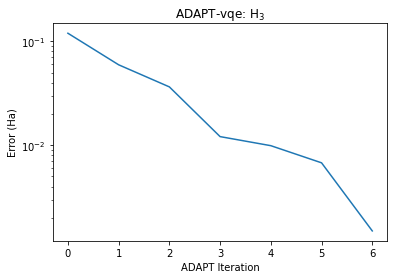

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from qsdk.electronic_structure_solvers.ccsd_solver import CCSDSolver

solver = CCSDSolver(mol)
exact = solver.simulate()
errors = np.array(adapt_solver.energies) - exact
fig,ax = plt.subplots(1,1)
ax.plot(errors)
ax.set_xlabel('ADAPT Iteration')
ax.set_ylabel('Error (Ha)')
ax.set_title('ADAPT-vqe: H$_3$')
ax.set_yscale('log')
print(f'Final Error: {errors[-1] :.4E}')

Ok so after 15 cycles, we have an error of 1.4 mHa, within chemical accuracy of FCI. How does this all compare against UCCSD-VQE?

In [59]:
from qsdk.electronic_structure_solvers.vqe_solver import VQESolver

vqe_uccsd = VQESolver({'molecule': mol})
vqe_uccsd.build()
vqe_uccsd.simulate()

converged SCF energy = -1.88779030448592
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0281387578384398
            Iterations: 6
            Function evaluations: 97
            Gradient evaluations: 6


-2.0281387578384398

In [60]:
print(f'ADAPT-VQE ERROR: {adapt_solver.energies[-1] - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {vqe_uccsd.optimal_energy - exact :0.4E} Ha')

ADAPT-VQE ERROR: 1.4956E-03 Ha
UCCSD-VQE ERROR: 1.5682E-03 Ha


From the perspective of energy accuracy, the two have reached very similar results. The big advantage here however, are in the resources required for this ansatz circuit:

In [61]:
print(f'ADAPT RESOURCES:\n {adapt_solver.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {vqe_uccsd.get_resources()}')

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2308, 'circuit_2qubit_gates': 1152, 'circuit_var_gates': 128, 'vqe_variational_parameters': 7}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}


We have managed here to reduce the total number of variational parameters by a factor of two while keeping all the gate requirements similar. With Adapt-VQE, the scaling of the number of parameters that need to be optimized should be better than the $\mathcal{O}(N^2M^2)$ scaling of UCCSD-VQE.

## Conclusion

In this notebook, we've explored a simple implementation of the ADAPT-VQE algorithm, using the implementation available in qSDK. We have demonstrated how we can leverage these tools to reduce the effort involved in prototyping new quantum algorithms. This allows the user to focus exclusively on the specific components relevant to their research objectives, without getting bogged down in re-building standard infrastructure from scratch. 

If you wish to look at a Qubit Hamiltonian, please look at the qubit_adapt.ipynb notebook in the user_notebooks folder.
